In [23]:
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
climate_disaster = 'Data/Climate_Disaster_Data/24_Climate-related_Disasters_Frequency.csv'
climate_disaster_df = pd.read_csv(climate_disaster)
climate_disaster_df.drop(columns=['Country','ISO2','Source','CTS Code', 'CTS Full Descriptor','Unit','CTS Name','Climate Influence'], inplace=True)
climate_disaster_df['Indicator'] = climate_disaster_df['Indicator'].str.split(',|:',expand=True)[2].str.strip()
climate_disaster_df = climate_disaster_df[climate_disaster_df['Indicator'] != 'TOTAL']
climate_disaster_df = pd.melt(climate_disaster_df, id_vars=['ISO3','Indicator'],var_name='Year', value_name='Frequency')

It's better to replace null with `0` by EAD defination of climate disaster:
- Killed ten (10) or more people 
- Affected hundred (100) or more people 
- Led to declaration of a state of emergency
- Led to call for international assistance  

<AxesSubplot: xlabel='Year'>

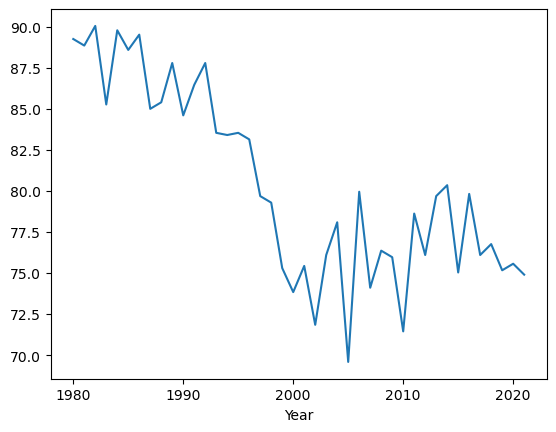

In [4]:
null_count = climate_disaster_df['Frequency'].isnull().groupby(climate_disaster_df['Year']).sum()
total_count = climate_disaster_df['Frequency'].groupby(climate_disaster_df['Year']).count()
climate_disaster_df['Frequency'].fillna(0, inplace=True)
climate_disaster_df['Year']= climate_disaster_df['Year'].astype('int64')
null_proportion = 100 * null_count/(total_count+null_count)

null_proportion.plot.line()

In [127]:
climate_disaster_df.to_csv('Data/Cleaned_Datasets/Climate/climate_disasters.csv', index=False)
climate_disaster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31626 entries, 0 to 31625
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ISO3       31626 non-null  object 
 1   Indicator  31626 non-null  object 
 2   Year       31626 non-null  int64  
 3   Frequency  31626 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 988.4+ KB


# Climate Disaster EDA

<AxesSubplot: xlabel='Year'>

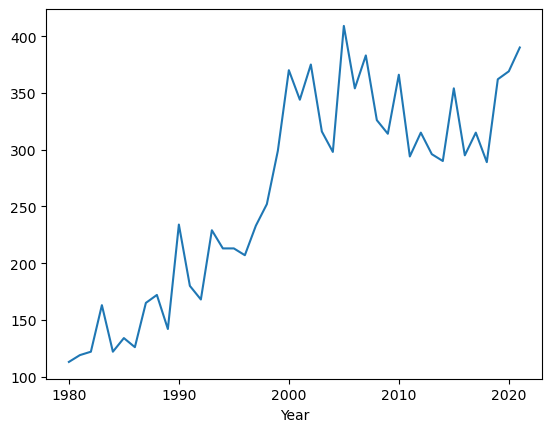

In [6]:
climate_disaster_df.groupby('Year')['Frequency'].sum().plot.line()

Frequency of disasters has been increasing steadily up to the mid 90's. It could be related to more data being gathered around the early 2000's or disasters definition being changed.

<AxesSubplot: xlabel='Year'>

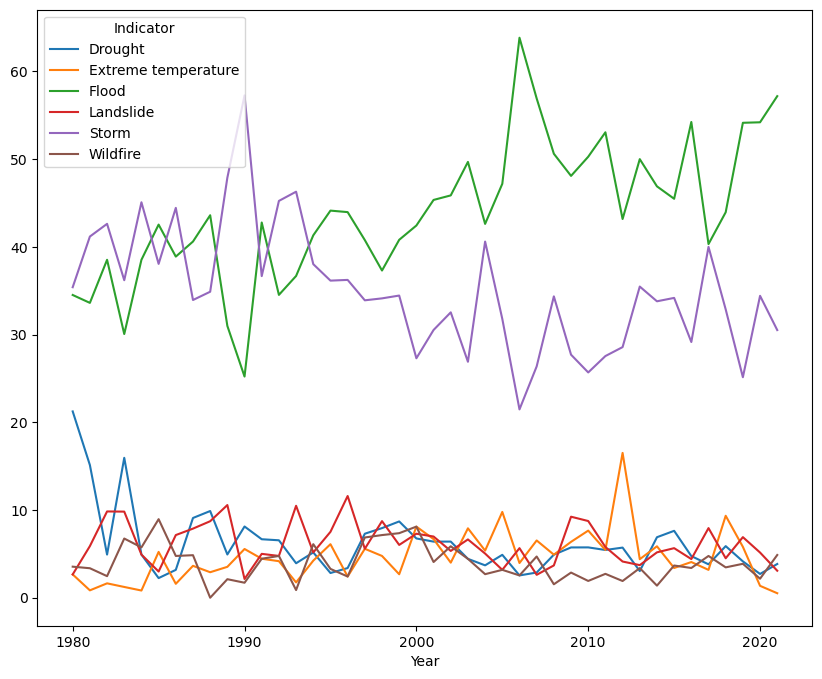

In [221]:
t = climate_disaster_df.groupby(['Year','Indicator'])['Frequency'].sum().to_frame().reset_index().pivot_table(index='Year', columns='Indicator',values='Frequency',aggfunc='sum')

t['Total'] = t.apply(lambda row: row.sum(), axis=1)


df_percentage = t.div(t['Total'], axis=0).mul(100)


df_percentage.drop(columns='Total').plot.line(figsize=(10,8))

The proportion of Flood as the cause of a disaster started around the mid 2000's at the same time when disasters overall increased. 
- Flood seems to be correlated with storms. Will this occur at the same year and same country?

In [95]:
storms_floods = climate_disaster_df[climate_disaster_df['Indicator'].isin(['Flood','Storm'])]
table_srm_flds = pd.pivot_table(storms_floods,values='Frequency',index=['ISO3','Year'], columns='Indicator', aggfunc=np.sum).reset_index()

<AxesSubplot: xlabel='Storm_log', ylabel='Flood_log'>

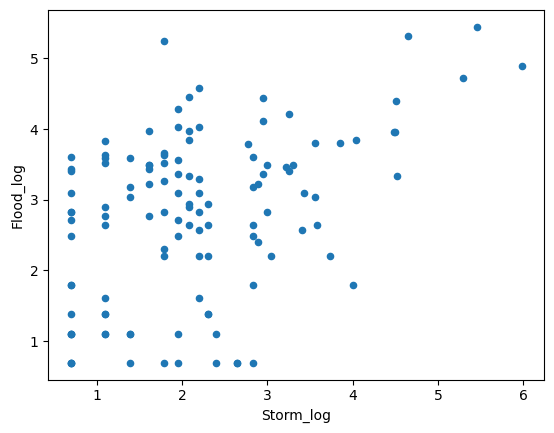

In [230]:
strm_flds_by_country = table_srm_flds.reset_index()[['ISO3','Flood','Storm']].groupby('ISO3').sum().reset_index()
strm_flds_by_year = table_srm_flds.reset_index()[['Year','Flood','Storm']].groupby('Year').sum().reset_index()

strm_flds_by_country['Flood_log'] = strm_flds_by_country.apply(lambda x: np.emath.log(x['Flood']) if x['Flood'] > 0 else 0, axis=1)
strm_flds_by_country['Storm_log'] = strm_flds_by_country.apply(lambda x: np.emath.log(x['Storm']) if x['Storm'] > 0 else 0, axis=1)

strm_flds_by_country[(strm_flds_by_country['Storm_log'] > 0)  & (strm_flds_by_country['Flood_log'] > 0)].plot.scatter(x='Storm_log',y='Flood_log')

<AxesSubplot: xlabel='Storm', ylabel='Flood'>

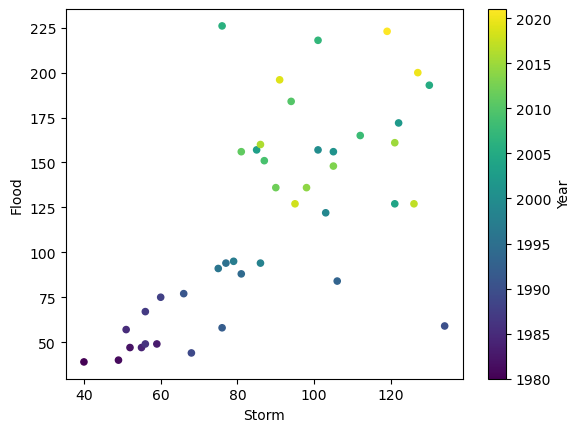

In [118]:
strm_flds_by_year.plot.scatter(x='Storm',y='Flood',c='Year',colormap='viridis')

In [128]:
country_info = pd.read_csv('Data/Cleaned_Datasets/General/country_information.csv')
climate_disaster_exp = climate_disaster_df.merge(country_info,how='inner',left_on='ISO3',right_on='ISO3')

In [194]:
climate_disaster_exp['Coastline'] = climate_disaster_exp.apply(lambda x: np.emath.log(x['Coastline'] * x['Area']*100) if x['Coastline'] > 0 else 0,axis=1)
climate_disaster_exp['Area'] = climate_disaster_exp.apply(lambda x: np.emath.log(x['Area']) ,axis=1)

In [212]:
storms_floods = climate_disaster_exp[['ISO3','Area','Coastline','Indicator','Frequency','Year']][
            (climate_disaster_exp['Indicator'].isin(['Flood','Storm'])) & (climate_disaster_exp['Year'] >= 1995)
            ]

table_srm_flds = pd.pivot_table(storms_floods,values='Frequency',index=['ISO3','Year','Area','Coastline'], columns='Indicator', aggfunc=np.sum).reset_index()

In [213]:
aggregation = {'Area':'mean', 'Coastline':'mean','Flood':'sum','Storm':'sum'}

dis_country_area = table_srm_flds.groupby('ISO3',as_index=False).agg(aggregation)

<AxesSubplot: xlabel='Area', ylabel='Flood'>

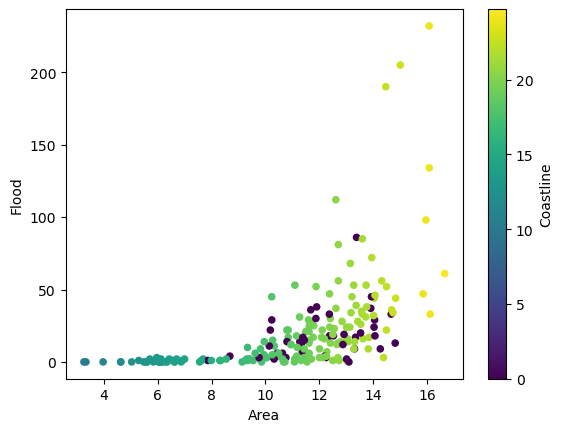

In [214]:
dis_country_area.plot.scatter(x='Area', y='Flood',c='Coastline',colormap='viridis')

<AxesSubplot: xlabel='Coastline', ylabel='Flood'>

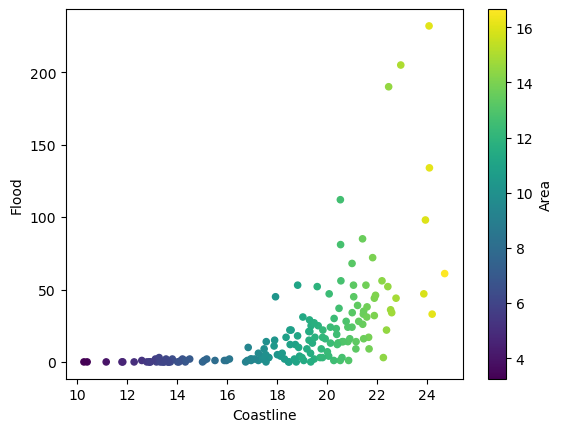

In [215]:
dis_country_area[dis_country_area['Coastline']>0].plot.scatter(x='Coastline', y='Flood',c='Area',colormap='viridis')

<AxesSubplot: xlabel='Coastline', ylabel='Storm'>

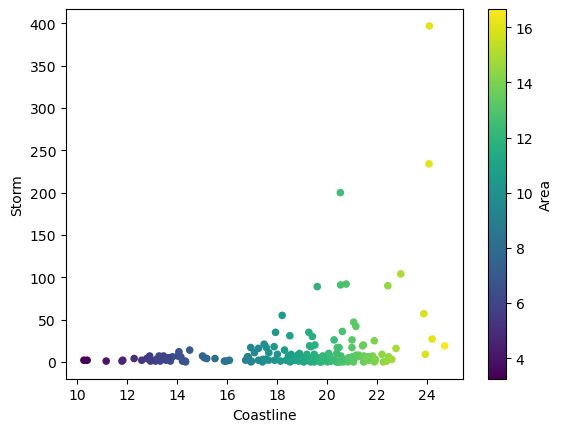

In [216]:
dis_country_area[dis_country_area['Coastline']>0].plot.scatter(x='Coastline', y='Storm',c='Area',colormap='viridis')